In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

## Preparando dados

In [2]:
dados = pd.read_csv('estrutura-esperada.csv', sep=';')

# Deixando somente as variáveis
del dados['id_review']

dados

,Nota,Bom,Ruim,Legal,Chato
0,3,1,0,1,0
1,3,0,0,1,0
2,2,0,0,1,1
3,2,0,0,1,0
4,1,0,0,0,0
5,1,1,1,0,0
6,1,0,0,0,1
7,2,0,0,0,0
8,2,0,0,0,0


In [3]:
# Normalizando os dados para valores booleanos

for column in dados.columns[1:]:
    dados[column] = dados[column] == 1

dados

,Nota,Bom,Ruim,Legal,Chato
0,3,True,False,True,False
1,3,False,False,True,False
2,2,False,False,True,True
3,2,False,False,True,False
4,1,False,False,False,False
5,1,True,True,False,False
6,1,False,False,False,True
7,2,False,False,False,False
8,2,False,False,False,False


In [4]:
# Transformando os dados para um Experimento
# Um experimento consegue computar a quantidade de ocorrências iguais (experiment.count())
from probability.experiment import Experiment

experiment = Experiment.from_dataframe(dados)
experiment.count()

Nota  Bom    Ruim   Legal  Chato
1     False  False  False  False    1
                           True     1
      True   True   False  False    1
2     False  False  False  False    2
                    True   False    1
                           True     1
3     False  False  True   False    1
      True   False  True   False    1
Name: (Nota, Bom, Ruim, Legal, Chato), dtype: int64

In [5]:
# Convertendo experimento para distribuição conjunta
from probability.new.joint_distribution import JointDistribution

P = JointDistribution.from_experiment(experiment)
P

Nota  Bom    Ruim   Legal  Chato
1     False  False  False  False    1/9
                           True     1/9
      True   True   False  False    1/9
2     False  False  False  False    2/9
                    True   False    1/9
                           True     1/9
3     False  False  True   False    1/9
      True   False  True   False    1/9
Name: P(Nota, Bom, Ruim, Legal, Chato), dtype: object

## Analisando os dados

In [6]:
from probability.probability_distribution import ProbabilityDistribution

In [7]:
Nota, Bom, Legal = P.variables.Nota, P.variables.Bom, P.variables.Legal

In [8]:
# Distribuição probabilística:
# Distribuição conjunta
P(Nota, Bom, Legal)

Nota  Bom    Legal
1     False  False    2/9
      True   False    1/9
2     False  False    2/9
             True     2/9
3     False  True     1/9
      True   True     1/9
Name: P(Nota, Bom, Legal), dtype: object

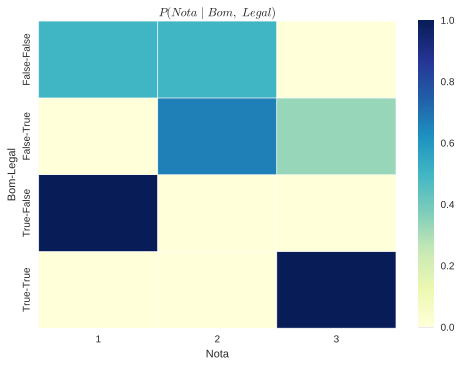

In [9]:
# Distribuição probabilística:
# Distribuição condicional

P(Nota | Bom, Legal).plot()

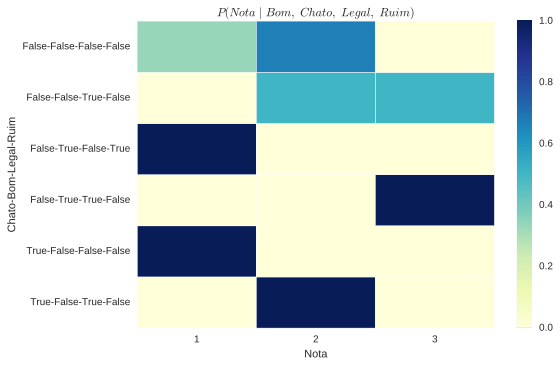

In [10]:
# Distribuição condicional com todas as variáveis
P(Nota | Bom, ...).plot()

## Naive Bayes

### Independence variable

Check if $Bom ⊥ Legal\ \mid\ Nota$

In [16]:
# Bom ⊥ Legal | Nota
P(Bom, Legal | Nota) == P(Bom|Nota) * P(Legal|Nota)

True

In [17]:
P(Bom, Nota, Legal) == P(Bom|Nota) * P(Legal|Nota) * P(Nota)

True

In [19]:
# P(X | Y, Z) = P(X | Y) if P |= (S ⊥ G | I)
# ???
#P(Bom | Nota, Legal) == P(Bom | Nota)

In [25]:
#P(Nota) * P((Bom==True)|Nota) * P((Legal==True)|Nota)
P(Nota) * P(Bom|Nota) * P(Legal|Nota)

Nota  Bom    Legal
1     False  False    2/9
      True   False    1/9
2     False  False    2/9
             True     2/9
3     False  True     1/9
      True   True     1/9
Name: P(Nota) P(Bom | Nota) P(Legal | Nota), dtype: object

### arg max

$\DeclareMathOperator*{\argmax}{arg max}$
$\DeclareMathOperator*{\argmin}{arg min}$


In [15]:
P.argmax()

TypeError: unhashable type: 'Assignment'

$$\argmax_{y \in \{y_1, ..., y_n\}} P(Y=y, X_0, ..., X_n)$$
$$\argmax_{nota \in Val(Nota)} P(Nota = nota\ |\ Bom, Legal)$$

In [26]:
P(Nota | Bom, Legal).argmax(Nota)

TypeError: unhashable type: 'Assignment'

-----------

In [27]:
valores = (False, True, False, True)

generator = (Variable==value for Variable, value in zip(valores, P.variables[1:]))
assignments = tuple(generator)

assignments

(Bom = False, Ruim = True, Legal = False, Chato = True)

In [29]:
def produtorio(assignments):
    resultado = P(Nota)

    for assignment in assignments:
        #resultado *= P(assignment.random_variable | Nota)(assignment, Nota)
        resultado *= P(assignment | Nota)#.reduction(assignment)
    
    return resultado

ProbabilityDistribution.from_joint_distribution(P(Bom, Legal | Nota).series)#.marginalize_out(Nota)
P(Bom, Legal | Nota).to_dataframe()

produtorio(assignments)

TypeError: unhashable type: 'Assignment'

In [30]:
# Marginalização
P(Bom, Legal | Nota) == P(Bom, Legal, Nota) / P(Nota)
P(Bom | Nota) == P(Bom, Legal, Nota).marginalize_out(Legal) / P(Nota)

P(Nota | Bom, Legal) == P(Bom, Legal, Nota) / P(Bom, Legal)
P(Nota | Bom) == P(Bom, Legal, Nota).marginalize_out(Legal) / P(Bom, Legal).marginalize_out(Legal)

True

In [31]:
P(Nota | Bom, Legal)

Bom    Legal  Nota
False  False  1       1/2
              2       1/2
       True   2       2/3
              3       1/3
True   False  1         1
       True   3         1
Name: P(Nota | Bom, Legal), dtype: object

In [32]:
# ERRADO
P(Nota | Bom, Legal).reduction(Bom==True)

Bom    Legal  Nota
False  False  2       0.5
Name: P(Nota | Bom, Legal), dtype: float64

In [33]:
P(Nota | (Bom==True), Legal==False)#.conditional_random_variable

TypeError: unhashable type: 'Assignment'

In [38]:
P((Nota==1) | Bom, Legal)

TypeError: unhashable type: 'Assignment'